In [1]:
import pygmt
import numpy as np
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as colours
import os
import requests
import geopandas as gpd
import shapely
import json
import cartopy.crs as ccrs


In [2]:
def australia(fig=None, region=[112, 155, -46, -8], projection=None, **kwargs):
    ln_min, ln_max, lt_min, lt_max = region
    if projection is None:
        projection = (
            f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/15c"
        )
    if fig is None:
        fig = pygmt.Figure()
        fig.basemap(region=region, projection=projection, frame=True)

    fig.coast(
        region=region, projection=projection, shorelines=1, resolution="i", **kwargs
    )
    return fig, region, projection


In [3]:
with open(
    os.path.join("data", "geological_timescale", "timeline_data.json"),
    "r",
) as read_file:
    main = json.load(read_file)
    geological_timeline = {m["id"].split("/")[-1]: m for m in main}

with open(
    os.path.join("data", "geological_timescale", "time_interval_data.json"), "r"
) as read_file:
    intervals = json.load(read_file)

for K, V in geological_timeline.items():
    for k, v in intervals.items():
        if k.split("/")[-1] == K:
            V |= v
            break
for K, V in geological_timeline.items():
    del V["name"]
    for k, v in V.items():
        if k == "narrow":
            V["children"] = [n.split("/")[-1] for n in v]
            del V[k]
        elif k == "broad":
            V["parent"] = [b.split("/")[-1] for b in v]
            del V[k]
            break


In [4]:
eras = {
    k: v
    for k, v in geological_timeline.items()
    if k in ["Cenozoic", "Mesozoic", "Paleozoic"]
}
periods = {}
for k, v in geological_timeline.items():
    if v["type"] == "period":
        if v["parent"][0] in eras.keys():
            periods[k] = v

# cmap = cm.get_cmap("Spectral", len(periods))
# for i, p in enumerate(periods):
#     periods[p]["fill"] = colours.to_hex(cmap(i))


In [5]:
url = "https://services.ga.gov.au/gis/services/Australian_Geological_Provinces/MapServer/WFSServer"
_eras = [
    "Cenozoic",
    "EarlyPaleozoic",
    "EarlyToLatePaleozoic",
    "LatePaleozoic",
    "Mesoproterozoic",
    "Mesozoic",
    "MesozoicCenozoic",
    "NeoproterozoicPaleozoic",
    "Paleoproterozoic",
    "PaleozoicCenozoic",
    "PaleozoicMesozoic",
]
base_typeName = "Australian_Geological_Provinces:SedimentaryBasins-"
params = {
    "request": "GetFeature",
    "service": "WFS",
    "version": "2.0.0",
    "typeName": base_typeName,
    "outputFormat": "geojson",
}
frames = []
for era in _eras:
    params["typeName"] = base_typeName + era
    r = requests.get(url=url, params=params)
    frames.append(gpd.GeoDataFrame.from_features(r.json()["features"]))

gdf = pd.concat(frames)
gdf.set_index("GmlID", inplace=True)
gdf.drop(gdf[gdf["onshoreOffshore"] == "Off"].index, inplace=True)

fills = []
ages = [] # mid point of period 'hasBeginning' and 'hasEnd', just to assign a numeric value
for i, polygon in gdf.iterrows():
    current_len = len(fills)
    name = polygon["olderNameAge"]
    if not isinstance(name, str):
        print(i)
        continue
    for p in name.split():
        if p in geological_timeline:
            _p = p
            _type = geological_timeline[_p]["type"]
            going_up = True
            while _type != "period":
                if going_up:
                    try:
                        _p = geological_timeline[_p]["parent"][0]
                    except IndexError: # no more parents
                        going_up = False
                else:
                    try:
                        _p = geological_timeline[_p]["children"][-1]  # oldest child
                    except IndexError as e: # no more children
                        raise e(f"No period found for {p}")
                _type = geological_timeline[_p]["type"]
            try:
                fills.append(periods[_p]['fill'])
                ages.append((periods[_p]['hasEnd'] + periods[_p]["hasBeginning"]) / 2)
            except KeyError: # precambrian
                fills.append("#80808080")
                ages.append(2500)
            break
    if len(fills) == current_len:
        fills.append(None)
        ages.append(None)
        
series = pd.DataFrame({"fill": fills, "period_age": ages}, gdf.index)
gdf = pd.concat([gdf, series], axis=1)
gdf.dropna(inplace=True, subset=["period_age"])

plot [WARNING]: Long input record (5110 bytes) was truncated to first 4093 bytes!
plot [WARNING]: Long input record (4272 bytes) was truncated to first 4093 bytes!


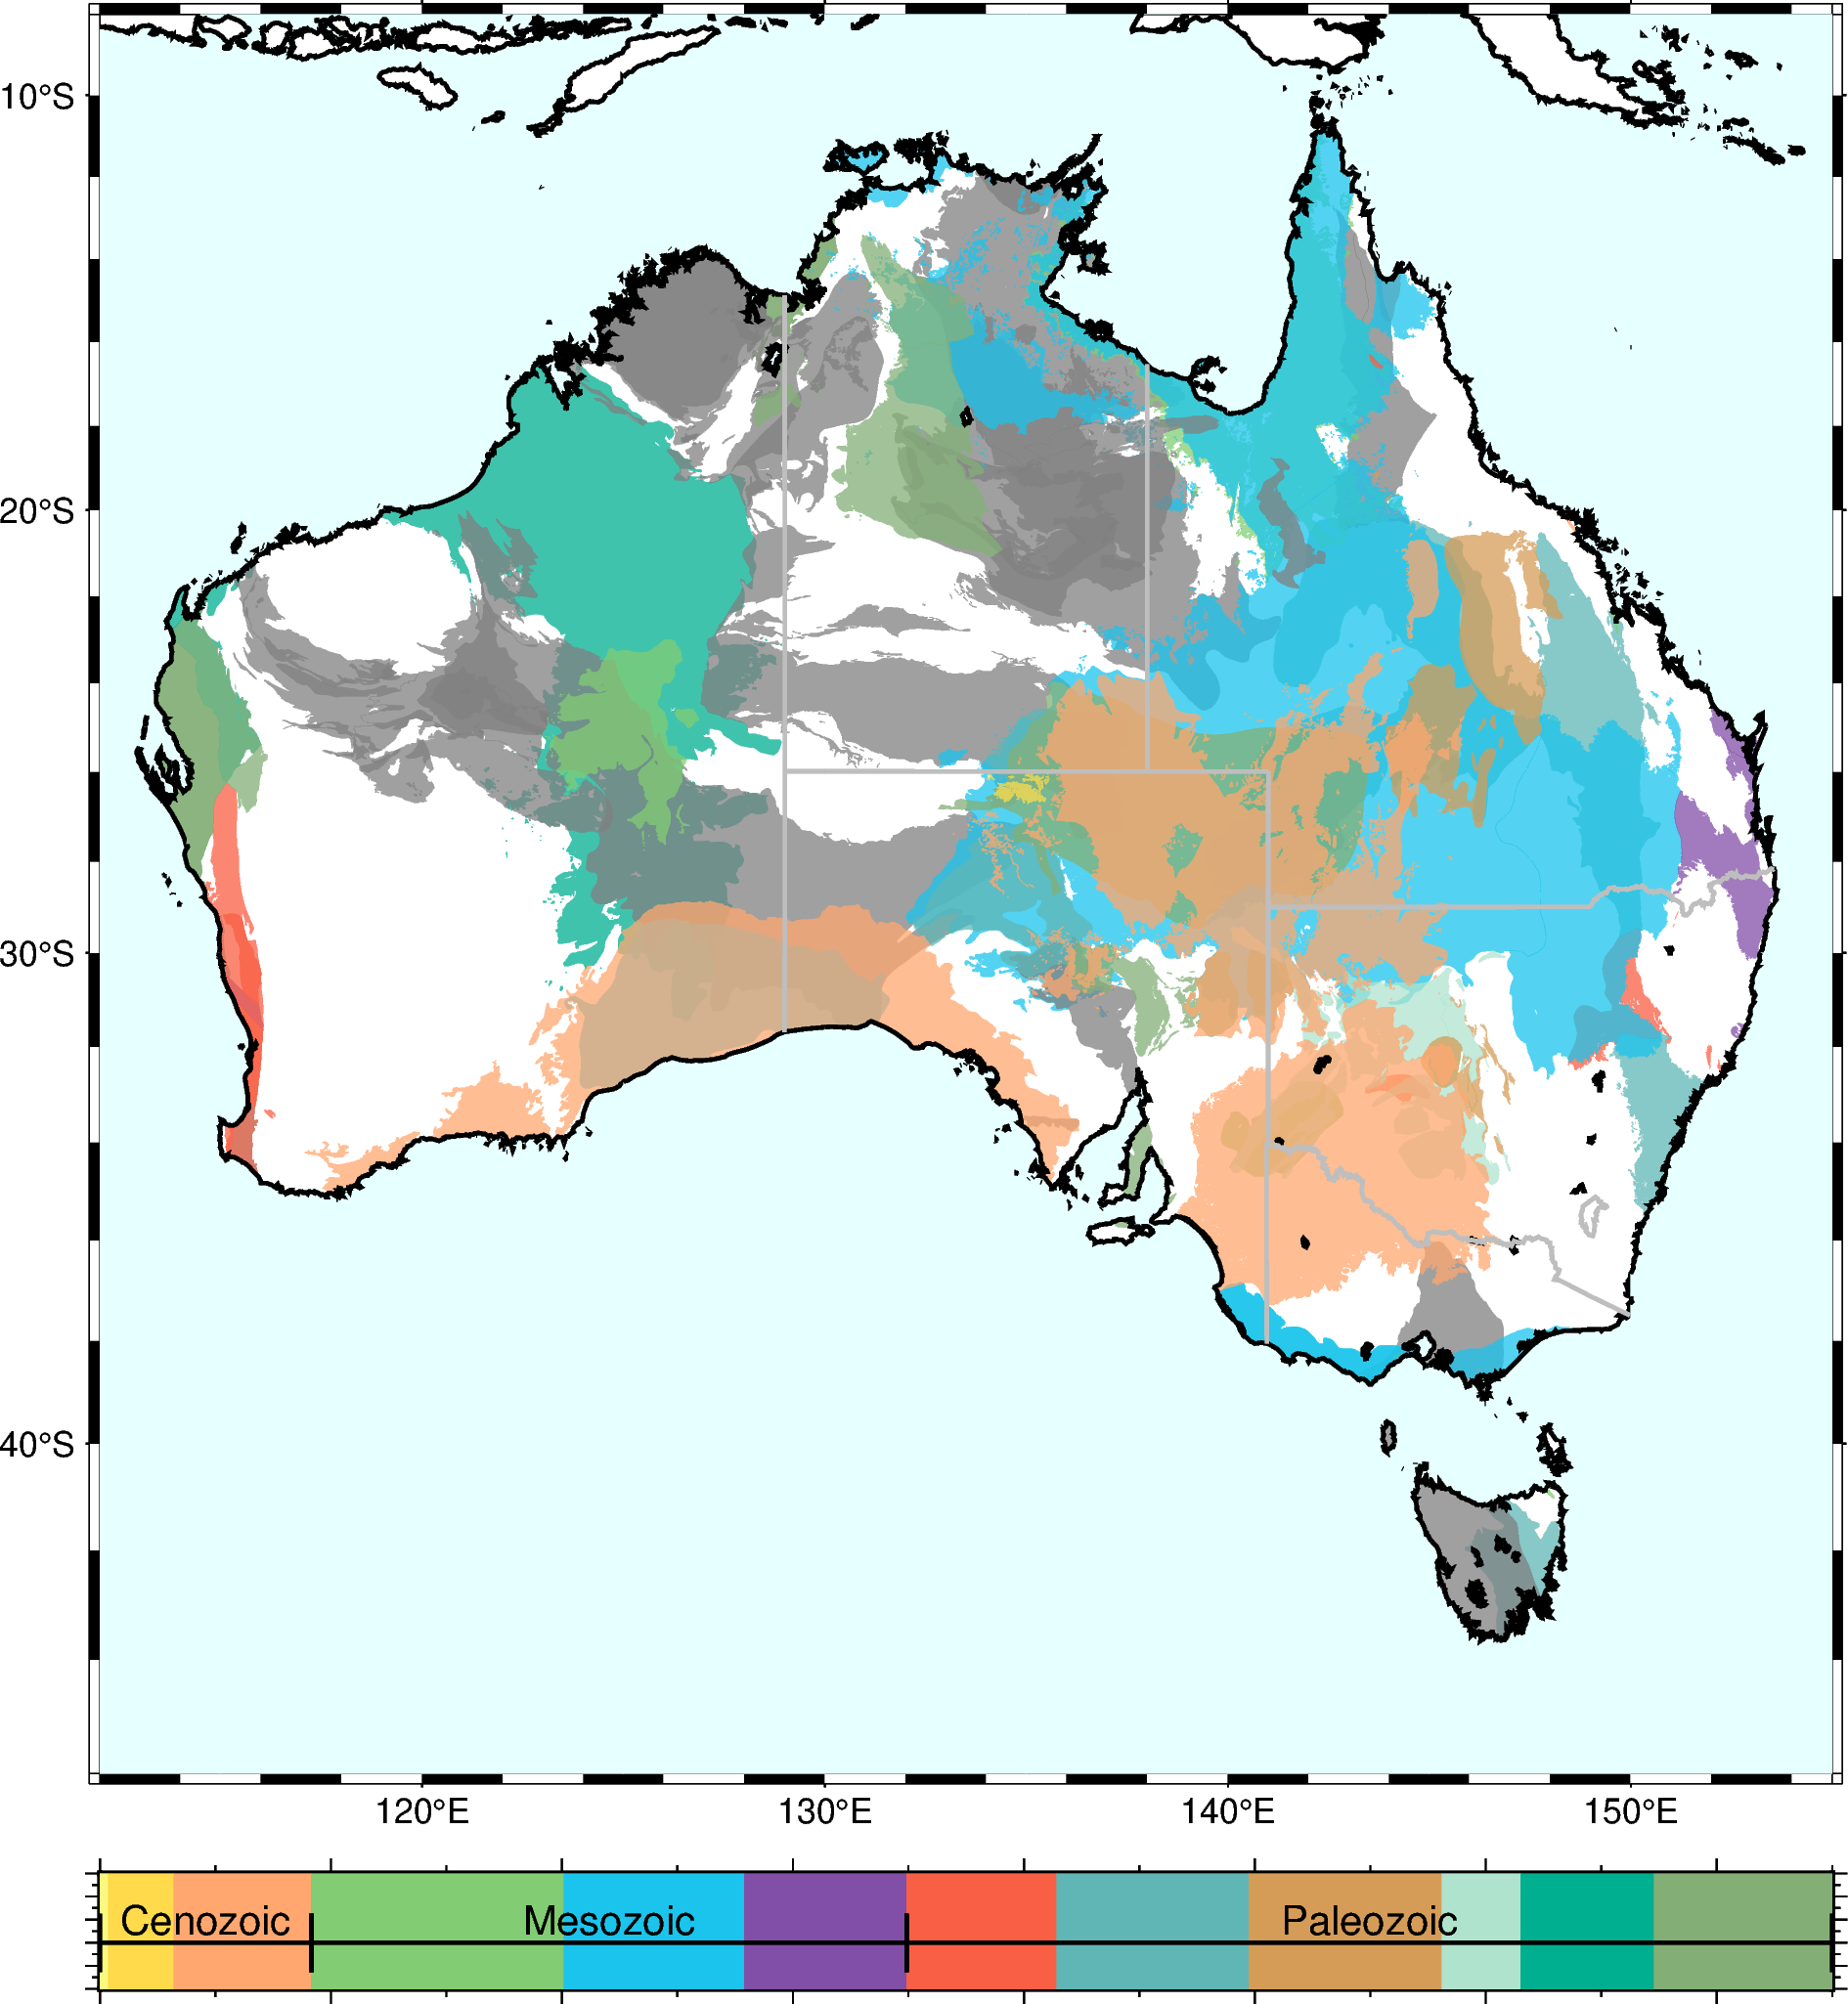

In [6]:
fig = pygmt.Figure()
fig_width = 15
with fig.subplot(nrows=2, ncols=1, figsize=(f"{fig_width}c", f"3c")):
    with fig.set_panel(0):
        region=[112, 155, -46, -8]
        ln_min, ln_max, lt_min, lt_max = region
        projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
        fig.basemap(region=region, projection=projection, frame=True)
        for i, polygon in gdf[::-1].iterrows():  # [::-1] flips the df to plot the oldest first
            # pygmt doesn't seem to have a nice way of colouring polygons
            # from a GeoDataFrame using a column to map to colours
            # so loop through and select the fill
            # Have to wrap each polygon into its own GeoDataFrame
            df = gpd.GeoDataFrame([polygon])
            fill = df["fill"].iloc[0]
            fig.plot(data=df, region=region, projection=projection, fill=fill, transparency=25)
        fig.coast(
            region=region,
            projection=projection,
            shorelines=1,
            resolution="i",
            water="#e6ffff",
            borders="2/1p,grey",
        )
    
    with fig.set_panel(1):
        region = [0, fig_width, 0, 1]
        projection = f"X{fig_width}c/1c"
        fig.basemap(region=region, projection=projection, frame=["wsne"])
        max_age = max([v["hasBeginning"] for v in periods.values()])

        def _scale_age_to_bar_length(age):
            return age / max_age * fig_width

        for i, p in enumerate(periods.values()):
            # fill = colours.to_hex(cmap(i))
            fill = p["fill"]
            beginning = _scale_age_to_bar_length(p["hasBeginning"])
            end = _scale_age_to_bar_length(p["hasEnd"])
            fig.plot(x=beginning, y=0.5, style=f"B1c+b{end}", fill=fill, region=region, projection=projection)

        font = "10p,Helvetica"
        for k, e in eras.items():
            beginning = _scale_age_to_bar_length(e["hasBeginning"])
            end = _scale_age_to_bar_length(e["hasEnd"])
            mid = (end + beginning) / 2
            length = beginning - end
            angle = 0
            fig.plot(x=end, y=0.4, style="v0.3c+bt+et+a80", direction=([angle], [length]), pen="1p", region=region, projection=projection)
            fig.text(x=mid, y=0.6, font=font, text=k, region=region, projection=projection)

fig.show()